In [1]:
#!pip install pyreadstat
#!pip install matplotlib seaborn
#!pip install mplcursors

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import mplcursors
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family']='Malgun Gothic'

In [4]:
#데이터 불러오기
raw_welfare = pd.read_spss('D:\syb_data\data\Koweps_hpda18_2023_beta1.sav')
#데이터 불러오기
raw_welfare_19 = pd.read_spss('D:\syb_data\data/Koweps_hpwc14_2019_beta2.sav')
#복사본 만들기
welfare = raw_welfare.copy()
#복사본 만들기
welfare_19 = raw_welfare_19.copy()

In [5]:
#데이터 검토
#welfare           # 앞부분, 뒷부분 확인
#welfare.shape     # 행, 열의 개수
#welfare.info()    # 열의 속성
#welfare.describe() # 요약통계

In [6]:
# 분석에 필요한 열을 결정 // 열 이름 변경
welfare = welfare.rename(
    columns= {'h18_g3' : 'sex',                # 성별
              'h18_g4' : 'birth',              # 태어난 년도
              'h18_g10' : 'marriage_type',    # 혼인 상태
              'h18_g11' : 'religion',          # 종교
              'p1802_8aq1' : 'income',         # 월급
              'h18_eco9' : 'code_job',         # 직업 코드
              'h18_reg7' : 'code_region',      # 지역 코드
              'h18_eco4' : 'eW' ,              # 주된 경제활동 참여상태
              'h18_eco11': 'no_eW',              #비경제활동사유
              'h18_g8' : 'disabled_type', #장애종류
              'h18_med3' : 'hospital_year', #1년간 의료기간 이용 외래진료횟수
              'h18_soc_5' : 'pension_status', #국민연급 납부여부                    
              })    


In [7]:
welfare_19 = welfare_19.rename(
    columns= {'h14_g3' : 'sex',                # 성별
              'h14_g4' : 'birth',              # 태어난 년도
              'h14_g10' : 'marriage_type',    # 혼인 상태
              'h14_g11' : 'religion',          # 종교
              'p1402_8aq1' : 'income',         # 월급
              'h14_eco9' : 'code_job',         # 직업 코드
              'h14_reg7' : 'code_region',       # 지역 코드
              'h14_eco4' : 'eW' ,              # 주된 경제활동 참여상태
              'h14_eco11' : 'no_eW',       # 비경제활동사유
              'h14_g8' : 'disabled_type', #장애종류
              'h14_med3' : 'hospital_year', #1년간 의료기간 이용 외래진료횟수
              'h14_soc_5' : 'pension_status', #국민연급 납부여부  
              })  

In [8]:
welfare = welfare.assign(age = 2019 - welfare['birth']+1 )
welfare['age'].describe()

count    15931.000000
mean        50.575984
std         24.226765
min         -2.000000
25%         32.000000
50%         55.000000
75%         71.000000
max        114.000000
Name: age, dtype: float64

In [9]:
welfare_19 = welfare_19.assign(age = 2019 - welfare['birth']+1 )
welfare_19['age'].describe()

count    14418.000000
mean        49.821889
std         24.318288
min         -2.000000
25%         31.000000
50%         53.000000
75%         71.000000
max        114.000000
Name: age, dtype: float64

In [10]:
#연령대에 따른 입금 차이
#초년층 : 30세 미만, 중년층 : 30~59세 , 노년층 : 60세 이상

#나이 변수 확인

welfare['age'].head()

0    75.0
1    72.0
2    78.0
3    58.0
4    57.0
Name: age, dtype: float64

In [11]:
welfare = welfare.assign(ageg = np.where(welfare['age']<30, 'young',
                                np.where(welfare['age']<=59, 'middle','old')))
welfare['ageg'].value_counts()

ageg
old       6914
middle    5339
young     3678
Name: count, dtype: int64

<Axes: xlabel='ageg', ylabel='count'>

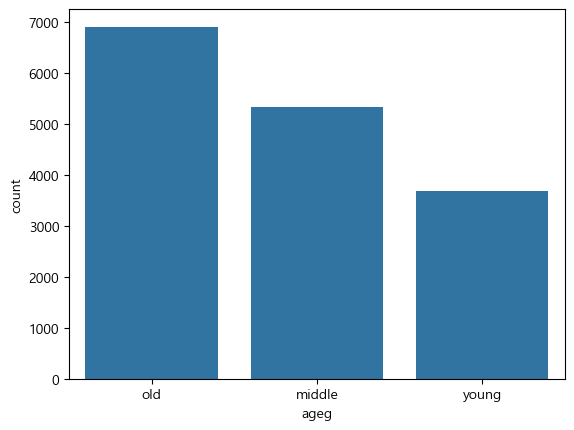

In [12]:
# 빈도 그래프
sns.countplot(data=welfare, x= 'ageg')

### 연령대 별 취업률과 실업률 비율 

In [13]:
welfare['eW'].describe()

count    14422.000000
mean         5.621620
std          3.330262
min          1.000000
25%          2.000000
50%          6.000000
75%          9.000000
max          9.000000
Name: eW, dtype: float64

In [14]:
welfare['eW'].dtype
welfare['eW'].value_counts() # 빈도수 

eW
9.0    6042
1.0    2757
2.0    1880
6.0    1627
4.0     746
7.0     544
3.0     477
5.0     199
8.0     150
Name: count, dtype: int64

In [15]:
#이상치 결측 처리 

welfare['eW']=np.where(welfare['eW'] == 99, np.nan, welfare['eW'])


# 결측 확인
print("결측 확인:", welfare['eW'].isna().sum()) 
welfare['eW'].isna().sum()

결측 확인: 1509


np.int64(1509)

In [16]:
welfare=welfare.dropna(subset=['eW'])

In [17]:
welfare = welfare.assign(ewg = np.where(welfare['eW'] <= 7, '취업률',
                               np.where(welfare['eW'] == 8, '실업률','비경제')))
welfare['ewg'].value_counts()

ewg
취업률    8230
비경제    6042
실업률     150
Name: count, dtype: int64

In [18]:
n_Employment =welfare.groupby('ewg',as_index=False)\
                 .agg(n= ('ewg','count'))
n_Employment

,ewg,n
0,비경제,6042
1,실업률,150
2,취업률,8230


<Axes: xlabel='ewg', ylabel='n'>

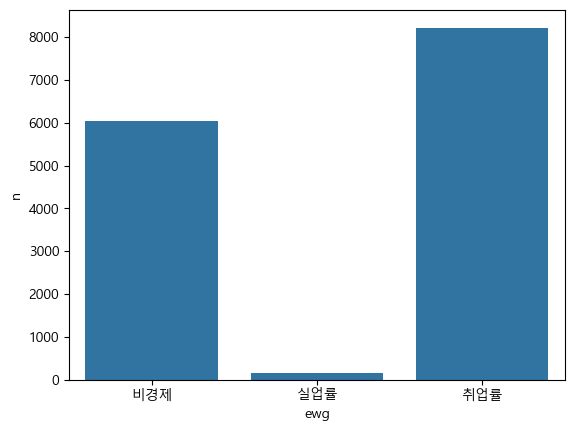

In [19]:
sns.barplot(data = n_Employment, x='ewg', y='n')


In [20]:
age_eW = welfare.groupby('ageg',as_index=False)\
                 ['ewg']\
                 .value_counts(normalize=True)
age_eW

,ageg,ewg,proportion
0,middle,취업률,0.785728
1,middle,비경제,0.199663
2,middle,실업률,0.014609
3,old,비경제,0.555395
4,old,취업률,0.440989
5,old,실업률,0.003616
6,young,비경제,0.523744
7,young,취업률,0.454587
8,young,실업률,0.021669


<Axes: xlabel='proportion', ylabel='ewg'>

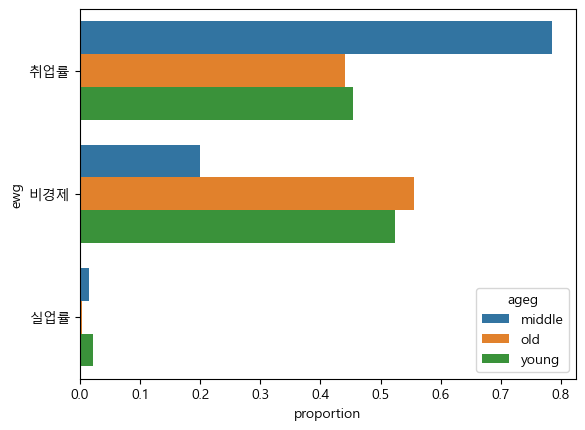

In [21]:
sns.barplot(data=age_eW, y='ewg', x='proportion',hue='ageg')


In [22]:
pivot_df=\
    age_eW[['ewg','ageg','proportion']].pivot(index='ewg',
                                              columns='ageg',
                                              values='proportion')
pivot_df

ageg,middle,old,young
ewg,,,
비경제,0.199663,0.555395,0.523744
실업률,0.014609,0.003616,0.021669
취업률,0.785728,0.440989,0.454587


<Axes: ylabel='ewg'>

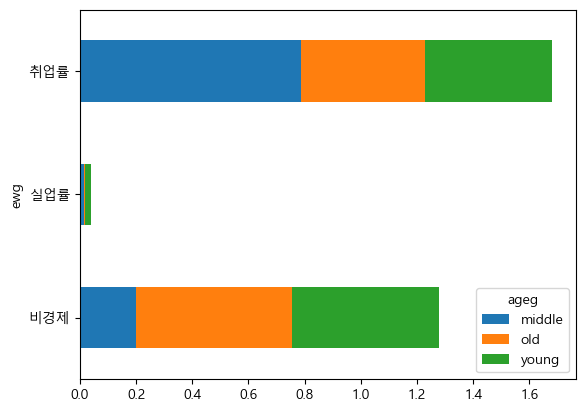

In [23]:
pivot_df.plot.barh(stacked=True)

In [24]:
welfare['no_eW'].dtype
welfare['no_eW'].value_counts() # 빈도수 

no_eW
10.0    3649
3.0      788
6.0      755
9.0      234
5.0      185
1.0      154
7.0      144
4.0       51
8.0       39
2.0       28
11.0      15
Name: count, dtype: int64

In [25]:
#이상치 결측 처리 

welfare['no_eW']=np.where(welfare['no_eW'] == 99, np.nan, welfare['no_eW'])


# 결측 확인
print("결측 확인:", welfare['no_eW'].isna().sum()) 
welfare['no_eW'].isna().sum()

결측 확인: 8380


np.int64(8380)

[23년도] '성별'과 '국민연금 납부여부' 항목 결측치 확인 및 대체

In [26]:
welfare['sex'].value_counts()

sex
2.0    8058
1.0    6364
Name: count, dtype: int64

In [27]:
# 결측확인
welfare['sex'].isna().sum()

np.int64(0)

In [28]:
# 성별, 항목 이름 부여
welfare['sex']=np.where(welfare['sex']==1,'male','female')

# 빈도 구하기
welfare['sex'].value_counts() # 빈도수

sex
female    8058
male      6364
Name: count, dtype: int64

In [29]:
welfare['pension_status'].value_counts('1')

pension_status
1.0    0.833923
2.0    0.166077
Name: proportion, dtype: float64

In [30]:
welfare['pension_status'].isna().sum()

np.int64(9617)

In [31]:
# 결측치의 개수 계산
missing_count = welfare['pension_status'].isna().sum()

# 각 값의 개수 계산
count_1 = int(missing_count * 0.8)  # 80%는 1로
count_2 = missing_count - count_1   # 나머지 20%는 2로

# 결측치를 채울 값 생성
fill_values = [1] * count_1 + [2] * count_2

# 결측치 위치의 인덱스 찾기
nan_indices = welfare[welfare['pension_status'].isna()].index

# 랜덤하게 결측치 인덱스를 선택하여 채우기
np.random.shuffle(fill_values)
welfare.loc[nan_indices, 'pension_status'] = fill_values

# 결과 확인
print("Pension Status Distribution After Filling:")
print(welfare['pension_status'].value_counts())

Pension Status Distribution After Filling:
pension_status
1.0    11700
2.0     2722
Name: count, dtype: int64


In [32]:
# 결측치 개수 0 확인
welfare['pension_status'].isna().sum()

np.int64(0)

In [33]:
# 국민연금 납부 여부 항목 이름 부여
welfare['pension_status']=np.where(welfare['pension_status']==1,'paid','unpaid')

[23년도] 성별에 따른 국민연금 납부 여부

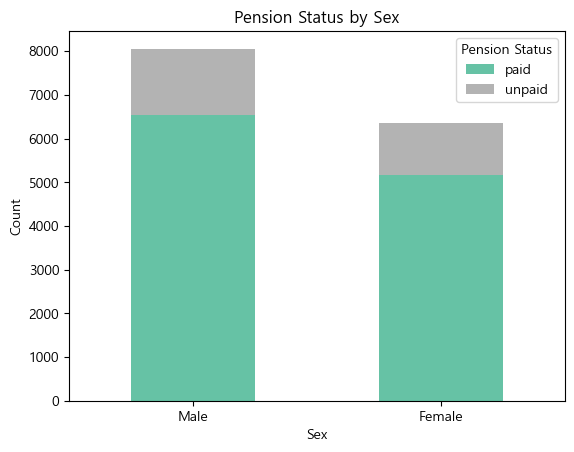

In [34]:
# 데이터 그룹화 및 집계
grouped_data = welfare.groupby(['sex', 'pension_status']).size().unstack()

# 막대 그래프 생성
grouped_data.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Pension Status by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Pension Status')
plt.xticks(ticks=range(len(grouped_data.index)), labels=['Male', 'Female'], rotation=0)
plt.show()

[23년도] '장애종류'와 '외래진료 횟수' 항목 결측치 확인 및 대체 및 제거

In [35]:
welfare['disabled_type'].isna().sum()

np.int64(0)

In [36]:
welfare['disabled_type'].value_counts()

disabled_type
0.0     12907
1.0       725
4.0       226
3.0       158
2.0       123
6.0        92
9.0        64
16.0       46
8.0        41
7.0         8
14.0        7
11.0        6
5.0         6
15.0        5
12.0        4
10.0        3
13.0        1
Name: count, dtype: int64

In [37]:
# 0:비장애인, 1:지체장애, 2:뇌병변장애, 3:시각장애, 4:청각장애 5~: 그 외

welfare['disabled']=np.where(welfare['disabled_type']==0, '비장애인',
                           np.where(welfare['disabled_type']==1,'지체장애',
                                    np.where(welfare['disabled_type']==2,'뇌병변장애',
                                             np.where(welfare['disabled_type']==3,'시각장애',
                                                      np.where(welfare['disabled_type']==4,'청각장애','그 외')))))

welfare['disabled'].head(10)

0    비장애인
1    비장애인
2    비장애인
3    비장애인
4    비장애인
5    비장애인
6    비장애인
7    비장애인
8    지체장애
9    비장애인
Name: disabled, dtype: object

In [38]:
welfare['hospital_year'].isna().sum()

np.int64(0)

In [39]:
# 외래진료횟수 150회 이상은 결측치로 처리
welfare['hospital_year']=np.where(welfare['hospital_year']>=150,np.nan,welfare['hospital_year'])

In [40]:
# 결측치 제거
welfare = welfare.dropna(subset=['hospital_year'])

[23년도] 장애종류에 따른 평균 외래진료 횟수

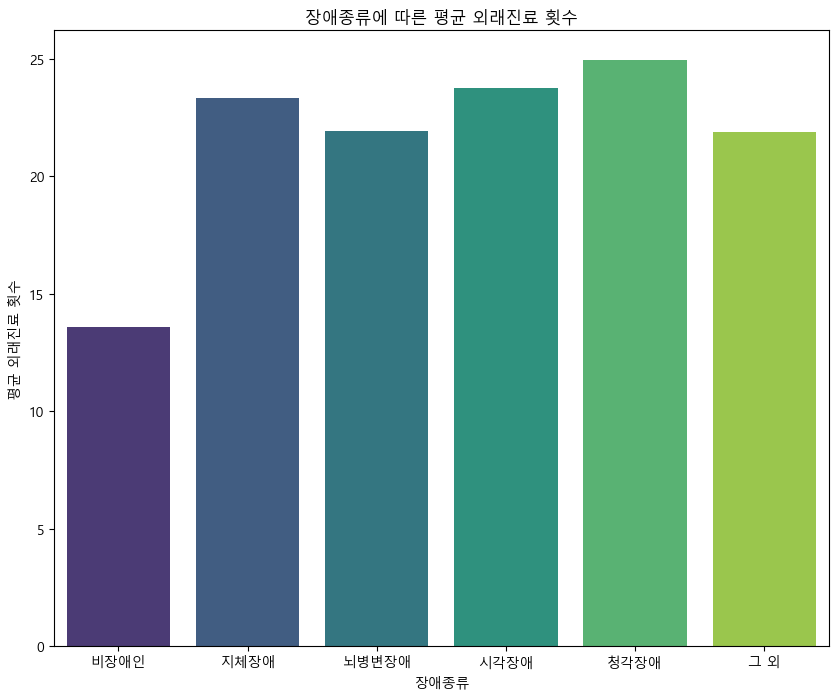

In [41]:
# 'disabled' 열의 각 범주별로 'hospital_year' 평균 계산
average_hospital_visits = welfare.groupby('disabled')['hospital_year'].mean().reset_index()

# 막대 그래프 생성
plt.figure(figsize=(10, 8))
sns.barplot(data=average_hospital_visits, x='disabled', y='hospital_year', palette='viridis', order=['비장애인','지체장애','뇌병변장애','시각장애','청각장애','그 외'])
plt.title('장애종류에 따른 평균 외래진료 횟수')
plt.xlabel('장애종류')
plt.ylabel('평균 외래진료 횟수')
plt.xticks(rotation=0)  # x축 레이블을 읽기 쉽게 회전
plt.show()

[23년도] '월급' 항목 결측치 확인 및 대체 및 제거

In [42]:
# 이상치는 결측 처리
welfare['income']=np.where(welfare['income']>=9500, np.nan, welfare['income'])

# 결측치 확인
welfare['income'].isna().sum()

np.int64(8693)

In [43]:
# 장애종류별 월급 평균
dis_income=welfare.dropna(subset=['income'])\
                  .groupby('disabled',as_index=False)\
                  .agg(mean_income=('income','mean'))
dis_income

,disabled,mean_income
0,그 외,249.941176
1,뇌병변장애,249.300000
2,비장애인,289.617702
3,시각장애,144.437500
4,지체장애,189.429530
5,청각장애,156.551724


[23년도] 장애종류별 평균 월급

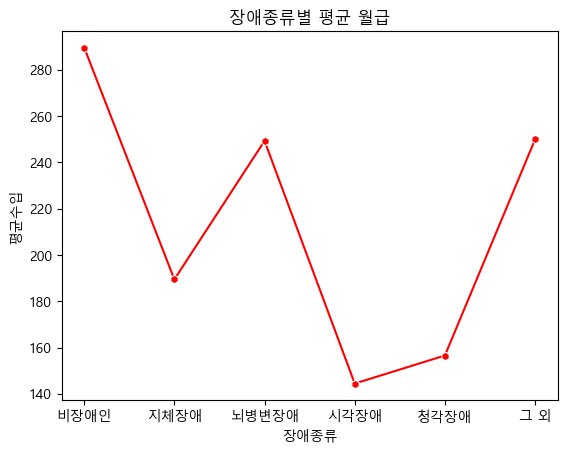

In [44]:
# 'disabled' 컬럼을 범주형으로 변환하고 순서 지정
dis_income['disabled'] = pd.Categorical(dis_income['disabled'], 
                                       categories=['비장애인', '지체장애', '뇌병변장애', '시각장애', '청각장애', '그 외'],
                                       ordered=True)

# 데이터 정렬
dis_income = dis_income.sort_values('disabled')


# 선 그래프 그리기
sns.lineplot(data=dis_income, x='disabled', y='mean_income', marker='h', color='red')
plt.title("장애종류별 평균 월급")
plt.xlabel('장애종류')
plt.ylabel('평균수입')
plt.xticks(rotation=0) # x축 범주들 글자 각도 조정, 필요에 따라 조절
plt.show()

[23년도] 장애인 취업률 구하기

In [45]:
welfare['eW'].isna().sum()

np.int64(0)

In [46]:
welfare = welfare.dropna(subset=['eW'])

In [47]:
welfare['eW'].value_counts()

eW
9.0    5957
1.0    2757
2.0    1872
6.0    1619
4.0     739
7.0     541
3.0     475
5.0     198
8.0     150
Name: count, dtype: int64

In [48]:
welfare['eW'] = np.where((welfare['eW'] == 8) | (welfare['eW'] == 9), '비근로자', '근로자')

In [49]:
welfare['eW'].value_counts('1')

eW
근로자     0.573176
비근로자    0.426824
Name: proportion, dtype: float64

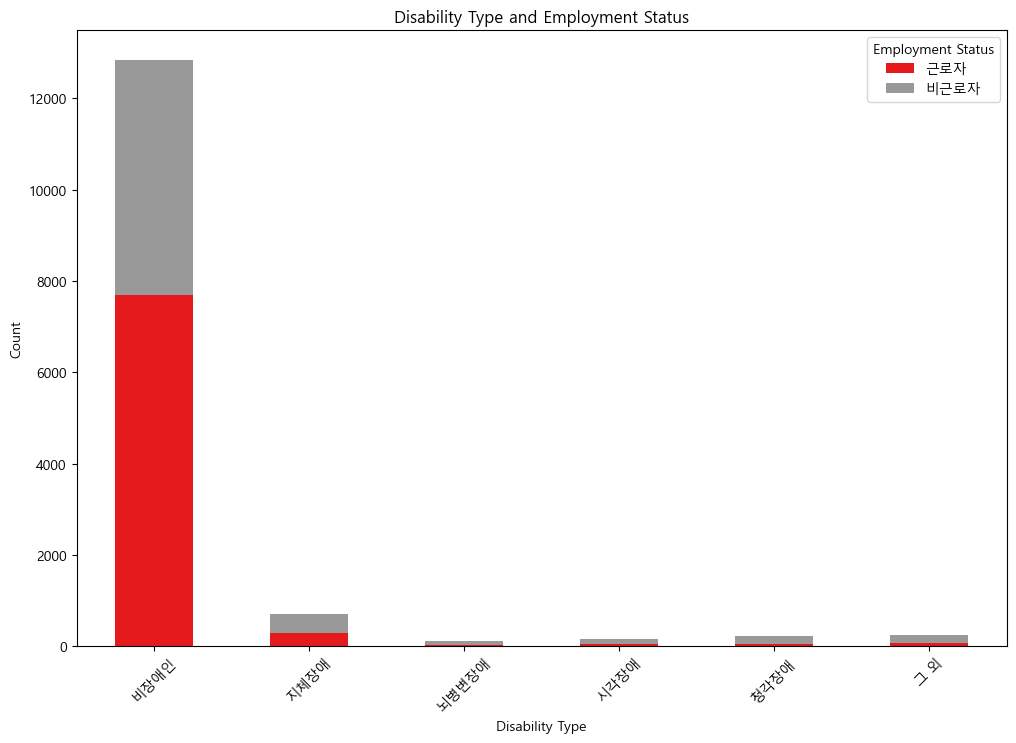

In [50]:
# 장애 종류의 순서를 지정하여 데이터 정렬
order = ['비장애인', '지체장애', '뇌병변장애', '시각장애', '청각장애', '그 외']
welfare['disabled'] = pd.Categorical(welfare['disabled'], categories=order, ordered=True)

# 데이터 그룹화 및 집계
grouped_data = welfare.groupby(['disabled', 'eW']).size().unstack().reindex(columns=['근로자', '비근로자'], fill_value=0)

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
ax = grouped_data.plot(kind='bar', stacked=True, colormap='Set1', ax=plt.gca())

# 제목 및 축 레이블 설정
plt.title('Disability Type and Employment Status')
plt.xlabel('Disability Type')
plt.ylabel('Count')

# x축 레이블 설정
plt.xticks(ticks=range(len(grouped_data.index)), labels=grouped_data.index, rotation=45)

# 범례 설정
plt.legend(title='Employment Status')

# 그래프 표시
plt.show()

In [51]:

# 장애 종류의 순서를 지정하여 데이터 정렬
order = ['비장애인', '지체장애', '뇌병변장애', '시각장애', '청각장애', '그 외']
welfare['disabled'] = pd.Categorical(welfare['disabled'], categories=order, ordered=True)

# 데이터 그룹화 및 집계
grouped_data = welfare.groupby(['disabled', 'eW']).size().unstack().reindex(columns=['근로자', '비근로자'], fill_value=0)

# 비장애인 제외
filtered_data = grouped_data.drop(index='비장애인')

# 비장애인을 제외한 나머지 범주의 총 수
total_counts_excluding_non_disabled = filtered_data.sum().sum()

# 비장애인을 제외한 나머지 범주에서 근로자의 총 수
total_employed_excluding_non_disabled = filtered_data['근로자'].sum()

# 비율 계산
employment_percentage = (total_employed_excluding_non_disabled / total_counts_excluding_non_disabled) * 100

# 결과 출력
print(f'장애인 중에서 근로자 비율: {employment_percentage:.2f}%')
print(f'장애인 중에서 비근로자 비율: {100-employment_percentage:.2f}%')

장애인 중에서 근로자 비율: 34.27%
장애인 중에서 비근로자 비율: 65.73%
